# __Snippet 1__
Here we are importing all the necessary libraries needed for this project.

In [12]:
# Import libraries
import matplotlib.pyplot as plt 
import numpy as np 
import pickle 
from sklearn.utils import shuffle 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import load_model 
from tensorflow.keras.utils import plot_model 
import cv2 
import openai 
from PIL import Image 

# __Snippet 2__
This code opens and reads the binary data stored in pickle, and labels each file accordingly. Then we split each files’ features and labels. Features are assigned values, and the labels are the things we are trying to predict. Then the data is shuffled, and ready to use!

In [13]:
# Open the training, validation, and test data sets
with open("./data/train.p", mode='rb') as training_data:
  train = pickle.load(training_data)
with open("./data/valid.p", mode='rb') as validation_data:
  valid = pickle.load(validation_data)
with open("./data/test.p", mode='rb') as testing_data:
  test = pickle.load(testing_data)
# Store the features and the labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# Shuffle the image data set
X_train, y_train = shuffle(X_train, y_train)

# __Snippet 3__
Now we grayscale and normalize the data, first by taking the average of the RGB values, on axis 3, and setting keepdims to true, so the dimensions stay the same. Then we normalize it by applying the formula for every pixel, such that the value of each pixel is between -1 and 1. Also, we pick an image and get its shape.

In [14]:
# Convert the RGB image data set into grayscale
X_train_grscale = np.sum(X_train/3, axis=3, keepdims=True)
X_test_grscale  = np.sum(X_test/3, axis=3, keepdims=True)
X_valid_grscale  = np.sum(X_valid/3, axis=3, keepdims=True)
# Normalize the data set
X_train_grscale_norm = (X_train_grscale - 128)/128
X_test_grscale_norm = (X_test_grscale - 128)/128
X_valid_grscale_norm = (X_valid_grscale - 128)/128
#Get an image shape
i = 1000
img_shape = X_train_grscale[i].shape

# __Snippet 4__
This is the architecture of our neural network. First there is a Conv2D layer which has a kernel size of a 3x3, which means it performs an operation on a 3x3 and its stride is also a 3x3, which means the Conv2D moves every 3x3, so that means that this layer is performing operations on every 3x3 of the picture. It extracts 32 features, since there are 32 filters. There is also an activation function called ReLu, and what it does is make all negative pixel values 0, but leaves the positive values alone. This helps model complex relationships between input and output. The next layer is similar, but has 64 filters, and a stride size of 1x1. Our next layer MaxPooling2D, down samples the image, by taking the maximum value of every 2x2 in the image. The dropout layer sets 25% of the pixels to 0, to avoid over-fitting which is when the model models the data too well, which actually negatively impacts the predictions. The flatten layer flattens the 2D array into a 1D vector. The dense layer is the neural network, with 128 input neurons, and uses ReLu. The dropout layer now sets half the units to 0, and the next dense layer has a sigmoid activation function, which gives us the probability of each output. 

In [15]:
# Build the neural network architecture
cnn_model = tf.keras.Sequential() # Plain stack of layers
cnn_model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), 
  strides=(3,3), input_shape = img_shape, activation='relu'))
cnn_model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), 
  activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(tf.keras.layers.Dropout(0.25))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(43, activation = 'sigmoid'))

# __Snippet 5__
This compile method is very common with image classification. First we set the loss to SCC, common with image classification, and define the Adam optimizer which controls things like learning rate, which controls the process. The metrics we tell it to measure are just accuracy, to see how accurate the model is. Now to train the model, we use the architecture from before. We use the features to predict the labels, given as x and y respectively. The batch size is after how many samples will the model update its parameters, and this affects the time taken to train and accuracy of a model. The model is trained 20 times over the dataset, which is the number of epochs. The verbose just displays a progress bar while trained, since it’s set to 1. The validation data is used to see if the model works well with unseen data. Then the model is saved in an h5 file for later use.

In [16]:
# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=(
  keras.optimizers.Adam(
  0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)), metrics =[
  'accuracy'])
# Train the model
history = cnn_model.fit(x=X_train_grscale_norm,
  y=y_train,
  batch_size=128,
  epochs=20,
  verbose=1,
  validation_data = (X_valid_grscale_norm,y_valid))
#Save the model
cnn_model.save("./road_sign.h5")

Epoch 1/20
272/272 [==============================] - 4s 14ms/step - loss: 2.5010 - accuracy: 0.3337 - val_loss: 1.2721 - val_accuracy: 0.6834
Epoch 2/20
272/272 [==============================] - 4s 14ms/step - loss: 1.0457 - accuracy: 0.6875 - val_loss: 0.6826 - val_accuracy: 0.8088
Epoch 3/20
272/272 [==============================] - 4s 14ms/step - loss: 0.6671 - accuracy: 0.7986 - val_loss: 0.5109 - val_accuracy: 0.8605
Epoch 4/20
272/272 [==============================] - 4s 14ms/step - loss: 0.5104 - accuracy: 0.8443 - val_loss: 0.3911 - val_accuracy: 0.9070
Epoch 5/20
272/272 [==============================] - 4s 14ms/step - loss: 0.4208 - accuracy: 0.8729 - val_loss: 0.3783 - val_accuracy: 0.8948
Epoch 6/20
272/272 [==============================] - 4s 14ms/step - loss: 0.3552 - accuracy: 0.8911 - val_loss: 0.3340 - val_accuracy: 0.9129
Epoch 7/20
272/272 [==============================] - 4s 15ms/step - loss: 0.3134 - accuracy: 0.9040 - val_loss: 0.3050 - val_accuracy: 0.9129

# __Snippet 6__
First the model's accuracy is evaluated, then printed. Then we get the accuracy for the test and validations datasets, and also the number of epochs. Using this information, we create a graph using matplotlib, which gives the accuracy as a function of epochs, for the training and validation datasets. This helps us better visualize the changes in accuracy with our model.

Test Accuracy : 0.9269


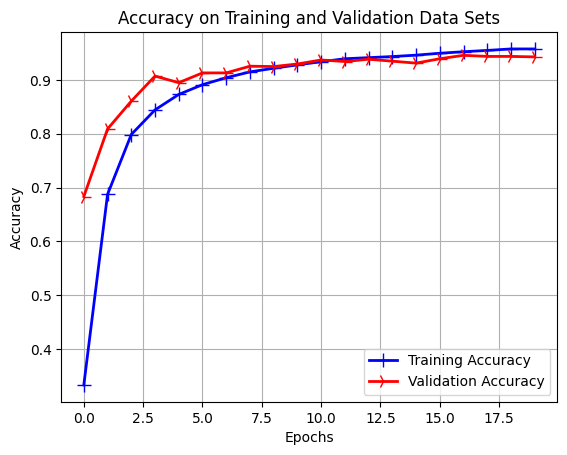

In [17]:
# Show the loss value and metrics for the model on the test data set
score = cnn_model.evaluate(X_test_grscale_norm, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))
# Get the accuracy statistics of the model on the training and validation data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
# Make a graph using matplotlib
line_1 = plt.plot(epochs, accuracy, color='blue', label='Training Accuracy')
line_2 = plt.plot(epochs, val_accuracy, color='red', label='Validation Accuracy')
plt.title('Accuracy on Training and Validation Data Sets')
plt.setp(line_1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line_2, linewidth=2.0, marker= '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show() 

# __Snippet 7__
Now, we get the class which has the highest probability of occurring, which is our prediction of the sign. After that, we use matplotlib to list some images, their predicted class and their actual class, which is then saved in a picture called "signs.png"

395/395 [==============================] - 1s 2ms/step


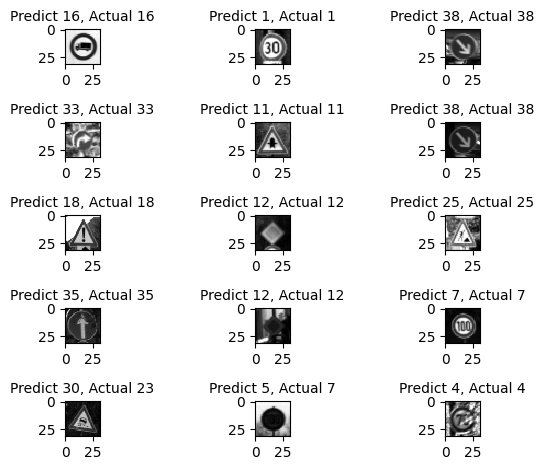

In [18]:
# Get the predictions for the test data set
predicted_classes = np.argmax(cnn_model.predict(X_test_grscale_norm), axis=-1)
# Retrieve the indices that we will plot
y_true = y_test
# Plot all possible classes using matplotlib
i = 0
for i in range(15):
  plt.subplot(5,3,i+1)
  plt.imshow(X_test_grscale_norm[i].squeeze(), 
    cmap='gray', interpolation='none')
  plt.title("Predict {}, Actual {}".format(predicted_classes[i], 
    y_true[i]), fontsize=10)
plt.tight_layout()
plt.savefig('signs.png')
plt.show()

# __Snippet 8__
Now in a new file, we load the mode from the h5 file. We get an image, and then gray scale and resize the image. Then we convert it into PIL (Python Imaging Library) format. This helps us preprocess and normalize the picture with ease, and then we use the model on the picture. Now we take the class with the biggest probability, and select that as a prediction. The new function here is predict, which is where we reshape the image to be like the expected image, 32x32, and then using the model we get our probabilities for each class. We also have a defined class_dict, which maps each class with the actual name of the sign, which we did manually. 

In [ ]:
# Load pre-trained model
model = tf.keras.models.load_model('./road_sign.h5')
class_dict = {0: 'Speed limit (20km/h)',
              1: 'Speed limit (30km/h)',
              2: 'Speed limit (50km/h)',
              3: 'Speed limit (60km/h)',
              4: 'Speed limit (70km/h)',
              5: 'Speed limit (80km/h)',
              6: 'End of speed limit (80km/h)',
              7: 'Speed limit (100km/h)',
              8: 'Speed limit (120km/h)',
              9: 'No passing',
              10: 'No passing for vehicles over 3.5 metric tons',
              11: 'Right-of-way at the next intersection',
              12: 'Priority road',
              13: 'Yield',
              14: 'Stop',
              15: 'No vehicles',
              16: 'Vehicles over 3.5 metric tons prohibited',
              17: 'No entry',
              18: 'General caution',
              19: 'Dangerous curve to the left',
              20: 'Dangerous curve to the right',
              21: 'Double curve',
              22: 'Bumpy road',
              23: 'Slippery road',
              24: 'Road narrows on the right',
              25: 'Road work',
              26: 'Traffic signals',
              27: 'Pedestrians',
              28: 'Children crossing',
              29: 'Bicycles crossing',
              30: 'Beware of ice/snow',
              31: 'Wild animals crossing',
              32: 'End of all speed and passing limits',
              33: 'Turn right ahead',
              34: 'Turn left ahead',
              35: 'Ahead only',
              36: 'Go straight or right',
              37: 'Go straight or left',
              38: 'Keep right',
              39: 'Keep left',
              40: 'Roundabout mandatory',
              41: 'End of no passing',
              42: 'End of no passing by vehicles over 3.5 metric tons'}
# Load the image and convert to grayscale
img = cv2.imread('input_image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Resize the image to 32x32 pixels
resized = cv2.resize(gray, (32,32), interpolation = cv2.INTER_AREA)
# Convert the image to PIL format
pil_image = Image.fromarray(resized)
# Preprocess the image
img_norm = (np.sum(np.expand_dims(np.array(pil_image), axis=-1)/3, axis=-1, keepdims=True) - 128) / 128
# Make a prediction
prediction = model.predict(img_norm.reshape(1, 32, 32, 1))
# Get the predicted class
predicted_class = class_dict[np.argmax(prediction)]

# __Snippet 9__
Now to tell our user about the sign, and what to do when they see it, we can use the ChatGPT API, to give it some instructions. First we tell it how the system should act, in this case telling people useful information about a road sign. We also give an example. Then using the predicted_class, we generate a response for the user. We also need the API key, which has been given before.

In [20]:
openai.api_key = 'YOUR_API_KEY' 
# Message generation using ChatCompletion
message = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant that gives users a description of a given road sign, and recommendations on what to do when they see it."},
        {"role": "user", "content": "What  should I do if I see a 65 mph sign"},
        {"role": "assistant", "content": "Keep your speed below 65 miles per  hour, as it will keep you safe."},
        {"role": "user", "content": "Tell me about this sign: " + predicted_class},
    ]
)
#Extract the output from json file
output = message.get('choices')[0]
content = output.get('message')
response = content.get('content')
print('This is the "' + predicted_class + '" sign. '  + response)

This is the "End of speed limit (80km/h)" sign. The "End of speed limit" sign indicates the point where a previously indicated speed limit ends. In this case, it means that the maximum speed limit of 80 kilometers per hour (km/h) that was previously in place on the road, has ended and there is no longer a legal speed limit enforced by the authorities. However, it is still important to maintain a safe and reasonable speed, taking into consideration the road conditions, weather, other road users, and the type and condition of your vehicle.
